# The "Marketplace" (Project: Dana)

### Background

The client is a global recruitment platform.

Their goal is to improve the relevance of their jobs marketplace which workers have access to based on the behaviour of the workers on the platform. The starting point is the UK market, and therefore other markets can be ignore for the time being.

Relevance is to be determined by whether a potential worker will apply to a job, or not.

Therefore there is no need for a strict yes/no output from the model, and instead the __probability__ of whether a worker will apply for a particular job or not is needed.

The dataset for this problem is to be determined and extracted by myself based on all the available data in their system.

### Problem Summary

* This is a classification problem.
* Need to determine the probability of a worker applying to all the jobs on the platform.
* There is no win condition.
* Focus on the UK market.

### Data Gathering: Insights

Due to the slow nature of the client's database, it was only possible to extract a week's worth of data, however the sample size was large enough for machine learning modelling.

### Summary of Findings

* A strong model with an ROC score of 0.89 was developed using the XGBoost algorithm.
* The model is ready to be deployed by the client.
* The model identified that in the UK the following play an important role in determining if someone will apply for a job:
    * Number of previous applications to a particular company
    * The average wage of previously applied roles
    * The wage of the job
    * The number of times a worker was previously hired by the company

### Further Recommendations

* Improvements can be done to the model by dropping some features, and further tunning the hyperparameters.
* A comprehensive CVGridSearch should be run instead of a RandomizedSearchCV to further optimise the hyperparameters. RandomizedSearchCV was used because CVGridSearch would have taken too long to run.
* Some quickly exploration was done for CH (beyond the scope of this work) and it seems that a different model is required for the CH market.
* Some additional features could be engineered. Examples:
    * How many times a worker viewed a particular job
    * Quantity of times a worker has declined different job types

## Library Imports

In [246]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns

# For connecting to the database to retrieve data
import pymysql

# A visualisation library
import missingno as msno 

# For calculating distances:
import geopy.distance

# For calculating time differences:
from datetime import datetime

# Math library for using math.isnan() function
import math

# For calculating the Z-score for outlier detection
from scipy import stats

## Define Global Styling Properties

In [247]:
# Define styling properties:
sns.set_style('whitegrid')
title_font = {'fontname':'Verdana', 'size':'20', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'18', 'color':'grey'}
ticks_font = {'size': '14', 'color':'grey', 'weight':'normal'}

font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

## Exploratory Analysis

#### Retrieve the data directly from the database

In [248]:
host = 'localhost'
port = 3307
user = 'USERNAME'
password = 'PASSWORD'
database = 'DATABASE'

conn = pymysql.connect(
    host=host,
    port=port,
    user=user,
    passwd=password,
    db=database)

In [249]:
df = pd.read_sql_query("SELECT * FROM DATABASE", conn)

In [251]:
df.shape

(100736, 31)

In [252]:
duplicates = df[df.duplicated()]
 
duplicates.shape

(0, 31)

No duplicate data found.

In [253]:
df.groupby(['status']).count()

,entry_id,country_id,job_id,p_id,c_id,role_id,date_declined,date_applied,date_rejected,date_hired,...,worker_longitude,job_wage,num_applied_role,num_rejected_role,num_applied_company,num_rejected_company,wage_applied_role,wage_hired_role,num_hired_role,num_hired_company
status,,,,,,,,,,,,,,,,,,,,,
applied,32154,32154,32154,32154,32154,32154,2556,32154,4616,2280,...,31980,32138,32154,32154,32154,32154,28771,4343,32154,32154
declined,68582,68582,68582,68582,68582,68582,68582,0,0,0,...,67350,68566,68582,68582,68582,68582,47296,3406,68582,68582


###### Remarks:
* There are 100,736 records in the dataset.
* There are no duplicates.
* 32,154 are in the 'applied' status, and
* 68,582 are in the 'declined' status. 
* We have a slightly imbalanced class.

In [254]:
df.groupby(['country_id']).count()

,entry_id,status,job_id,p_id,c_id,role_id,date_declined,date_applied,date_rejected,date_hired,...,worker_longitude,job_wage,num_applied_role,num_rejected_role,num_applied_company,num_rejected_company,wage_applied_role,wage_hired_role,num_hired_role,num_hired_company
country_id,,,,,,,,,,,,,,,,,,,,,
1,73794,73794,73794,73794,73794,73794,57713,17468,1746,1229,...,72670,73762,73794,73794,73794,73794,52494,4514,73794,73794
2,26928,26928,26928,26928,26928,26928,13424,14673,2868,1046,...,26646,26928,26928,26928,26928,26928,23567,3222,26928,26928
3,14,14,14,14,14,14,1,13,2,5,...,14,14,14,14,14,14,6,13,14,14


###### Remarks - Important:
* There are 3 countries in the dataset: Germany, UK and Denmark. We should split them apart since user behaviour can differ significantly between the 3.
    * DE: platform_id = 1
    * UK: platform_id = 2
    * DK: platform_id = 3
* Denmark can be dropped, since the client is not currently interested in it

In [255]:
# Let's make the CH and UK datasets available in separate dataframes
df_de = df[df['country_id'] == 1].copy()
df_uk = df[df['country_id'] == 2].copy()

In [256]:
df.head()

,entry_id,country_id,status,job_id,p_id,c_id,role_id,date_declined,date_applied,date_rejected,...,worker_longitude,job_wage,num_applied_role,num_rejected_role,num_applied_company,num_rejected_company,wage_applied_role,wage_hired_role,num_hired_role,num_hired_company
0,9111003f-dcd9-45b7-b8b0-02fef2771b24,1,applied,3957ab7d-a3fe-4a4b-a20a-e4bbb777b9ff,9f4e08ff-8690-4e89-b590-edcfe99e8cfc,0588fb6d-5e79-4cad-b957-d36347913fc5,72,NaT,2020-02-28 23:59:39,NaT,...,8.736907,25.00,7,0,0,0,25.068571,NaN,0,0
1,d8e0c803-3431-4e51-834c-2eff946dfb8f,1,applied,12175efb-ce22-47af-ba5c-4dc20e372e29,9f4e08ff-8690-4e89-b590-edcfe99e8cfc,28e59d7a-f842-452c-a53a-e2840b822e9e,72,NaT,2020-02-28 23:58:27,NaT,...,8.736907,23.32,6,0,0,0,25.360000,NaN,0,0
2,c204a359-a062-4491-b1c8-f61be7282af3,1,applied,4cb0b989-eb5b-49f7-9bd0-315c6ad39ab9,47442a43-e5d5-47be-90cb-a4091dc4bea1,76d88c4c-9085-4a59-ad35-b34b914964fb,4,NaT,2020-02-28 23:58:24,NaT,...,8.691771,25.50,2,0,0,0,25.450000,NaN,0,0
3,ec414ddd-c032-4225-98bf-e29546ac8397,1,applied,20390bb6-7e6a-4c06-b183-30ac12f7e3db,cd377b51-0839-4f8d-a50a-f5f8bec4f1a0,10cd2798-6c67-414c-ab60-fd45d4ca7d74,54,NaT,2020-02-28 23:58:16,NaT,...,8.556073,27.00,4,2,0,0,27.000000,NaN,0,0
4,3ab44063-0419-48cb-849d-4b0b040d4ce7,1,applied,82befe52-9bb1-49b3-9f65-41540909d66b,47442a43-e5d5-47be-90cb-a4091dc4bea1,10cd2798-6c67-414c-ab60-fd45d4ca7d74,54,NaT,2020-02-28 23:58:02,NaT,...,8.691771,27.00,2,0,2,0,27.000000,NaN,0,0


In [257]:
df.describe()

,country_id,role_id,job_title_length,job_description_length,job_time_dow_from,job_time_hour_from,job_time_dow_to,job_time_hour_to,job_latitude,job_longitude,...,worker_longitude,job_wage,num_applied_role,num_rejected_role,num_applied_company,num_rejected_company,wage_applied_role,wage_hired_role,num_hired_role,num_hired_company
count,100736.000000,100736.000000,100736.000000,100736.000000,100736.000000,100736.000000,100736.000000,100736.000000,100736.000000,100736.000000,...,99330.000000,100704.000000,100736.000000,100736.000000,100736.000000,100736.000000,76067.000000,7749.000000,100736.000000,100736.000000
mean,1.267591,172.111996,34.657531,385.039658,4.273735,11.566113,4.500069,16.261217,48.376277,5.955970,...,6.020770,22.481285,48.685594,6.177414,2.455607,0.290472,21.795773,21.457277,7.664460,0.478369
std,0.443019,316.612862,20.055864,447.395729,1.948131,3.833782,2.176146,5.633313,1.920780,3.732155,...,3.915476,23.992544,132.039984,23.128861,10.536597,1.674866,34.236833,46.894422,24.687474,5.196456
min,1.000000,1.000000,4.000000,0.000000,1.000000,1.000000,1.000000,0.000000,45.869585,-2.167194,...,-50.428290,8.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,37.000000,19.000000,88.000000,2.000000,9.000000,3.000000,15.000000,47.308527,-0.050900,...,0.067889,10.550000,1.000000,0.000000,0.000000,0.000000,9.675928,9.000000,0.000000,0.000000
50%,1.000000,72.000000,31.000000,224.000000,4.000000,11.000000,5.000000,17.000000,47.408211,7.928618,...,8.091019,25.450000,6.000000,0.000000,0.000000,0.000000,24.930000,23.350000,0.000000,0.000000
75%,2.000000,72.000000,47.000000,493.000000,6.000000,15.000000,6.000000,20.000000,51.455733,8.540323,...,8.554411,27.000000,39.000000,4.000000,1.000000,0.000000,25.897452,25.000000,3.000000,0.000000
max,3.000000,1037.000000,143.000000,2032.000000,7.000000,23.000000,7.000000,23.000000,53.359760,9.822876,...,99.825221,1000.000000,1824.000000,340.000000,502.000000,61.000000,3146.850000,1000.000000,380.000000,316.000000


###### Remarks
* There are many _id fields which need to be removed
* All the date fields can be removed too
* We have the location of the person and the job, so its possible to calculate the distance to work
* We have the job_wage and also the average wage of jobs a worker previously applied to, so we can calculate the delta and use that as a new feature
* There are no categorical data points to explore

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100736 entries, 0 to 100735
Data columns (total 31 columns):
entry_id                  100736 non-null object
country_id                100736 non-null int64
status                    100736 non-null object
job_id                    100736 non-null object
p_id                      100736 non-null object
c_id                      100736 non-null object
role_id                   100736 non-null int64
date_declined             71138 non-null datetime64[ns]
date_applied              32154 non-null datetime64[ns]
date_rejected             4616 non-null datetime64[ns]
date_hired                2280 non-null datetime64[ns]
date_job_created          100736 non-null datetime64[ns]
job_title_length          100736 non-null int64
job_description_length    100736 non-null int64
job_time_dow_from         100736 non-null int64
job_time_hour_from        100736 non-null int64
job_time_dow_to           100736 non-null int64
job_time_hour_to          100

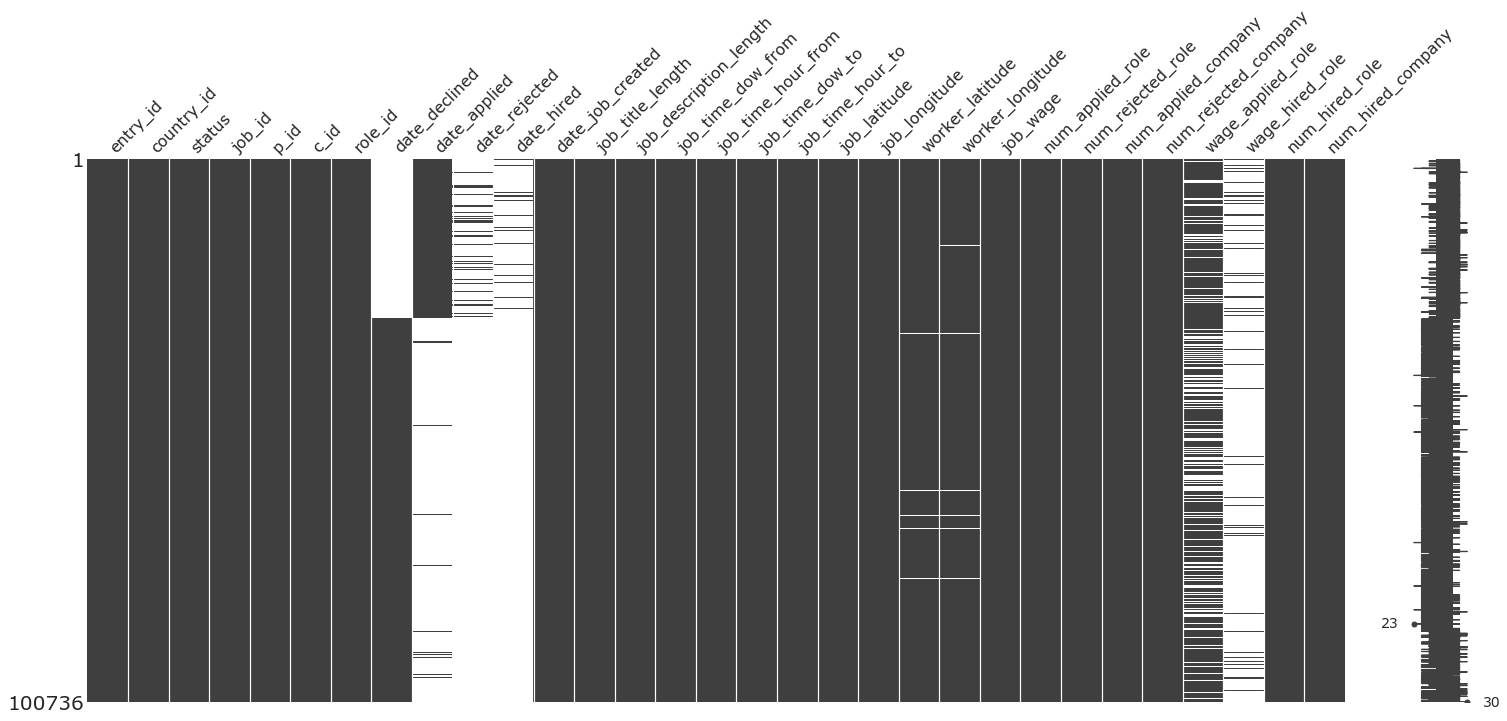

In [259]:
msno.matrix(df) 

In [71]:
df.isnull().sum()

entry_id                      0
country_id                    0
status                        0
job_id                        0
p_id                          0
c_id                          0
role_id                       0
date_declined             29598
date_applied              68582
date_rejected             96120
date_hired                98456
date_job_created              0
job_title_length              0
job_description_length        0
job_time_dow_from             0
job_time_hour_from            0
job_time_dow_to               0
job_time_hour_to              0
job_latitude                  0
job_longitude                 0
worker_latitude            1340
worker_longitude           1406
job_wage                     32
num_applied_role              0
num_rejected_role             0
num_applied_company           0
num_rejected_company          0
wage_applied_role         24669
wage_hired_role           92987
num_hired_role                0
num_hired_company             0
dtype: i

###### Remarks (missing data):
* There are some missing values which we'll need to deal with
* There are also days where someone had applied for a job, and then declined it. For those days we should probably set the "date_applied" to zero
* Some job_wage are missing. We'll set those to zero.

In [260]:
main_data_columns = [
    'job_title_length',
    'job_description_length',
    'job_wage',
    'num_applied_role',
    'num_rejected_role',
    'num_applied_company',
    'num_rejected_company',
    'wage_applied_role',
    'wage_hired_role',
    'num_hired_role',
    'num_hired_company'
]

In [261]:
df_de.groupby(['status'])[main_data_columns].mean()

,job_title_length,job_description_length,job_wage,num_applied_role,num_rejected_role,num_applied_company,num_rejected_company,wage_applied_role,wage_hired_role,num_hired_role,num_hired_company
status,,,,,,,,,,,
applied,35.419109,354.848752,28.541514,64.130524,8.185597,3.848466,0.382585,27.350596,26.917766,8.468628,0.901076
declined,35.263058,365.336683,26.929708,45.362497,6.421244,1.108316,0.142740,27.468214,30.777225,6.563665,0.181550


In [262]:
df_uk.groupby(['status'])[main_data_columns].mean()

,job_title_length,job_description_length,job_wage,num_applied_role,num_rejected_role,num_applied_company,num_rejected_company,wage_applied_role,wage_hired_role,num_hired_role,num_hired_company
status,,,,,,,,,,,
applied,32.254549,423.600423,9.359488,52.002522,4.792203,6.236352,0.690179,9.229202,10.166554,10.582839,1.196279
declined,33.682171,471.666422,9.134862,38.027907,3.859894,2.138229,0.359935,9.253604,12.665811,8.089270,0.378866


## Data Cleaning

There are no duplicates to remove.

Also, before we drop any unnecessary data points, we'll use them to engineer some new features.

#### Convert status into a numerical variable

In [263]:
df['status'] = pd.get_dummies(df.status).applied

## Feature Engineering

#### New feature: "distance_to_work"

Article on how to calculate the distance between 2 points:

https://stackoverflow.com/questions/60649233/python-pandas-error-the-truth-value-of-a-series-is-ambiguous-when-engineerin

In [264]:
# Function for calculating the distance
# This function will receive a row of data from the dataframe and return the distance or 0 if an error is encountered

def get_distance(row):
    try:
        # Since there are some missing worker coordinateds, we should deal with them:
        if not (math.isnan(row['worker_latitude']) or math.isnan(row['worker_longitude'])):
            distance = geopy.distance.geodesic((row['job_latitude'], row['job_longitude']), 
                                           (row['worker_latitude'], row['worker_longitude'])).km
            df['has_distance'] = 1
        else:
            distance = 0
            df['has_distance'] = 0
        return distance
    except ValueError as e:
        print(e)
        return 0

In [265]:
# Calculate the new distance feature
# For every row get_distance function is called and the row is passed into the function

df['distance_to_job'] = df.apply(get_distance, axis=1)

In [266]:
# Check that everything has worked:

df[['job_latitude','job_longitude','worker_latitude','worker_longitude','distance_to_job']].head()

,job_latitude,job_longitude,worker_latitude,worker_longitude,distance_to_job
0,47.384262,8.574091,47.497915,8.736907,17.620530
1,47.440155,8.557808,47.497915,8.736907,14.951225
2,47.408844,8.595373,47.421573,8.691771,7.411042
3,47.408299,8.595949,47.405884,8.556073,3.021688
4,47.408299,8.595949,47.421573,8.691771,7.380269


In [267]:
# Check for null values:
df.distance_to_job.isnull().sum()

0

#### New feature: "time_to_action" - how long it takes for the user to take action after a job is created

Remember that the datetime64 is a numpy object and is very specific (and experimental):

https://numpy.org/devdocs/reference/arrays.datetime.html   (NaT = Not a Time)

https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html#datetime-arithmetic

In [268]:
def get_time_diff(row):
    creation_date = row['date_job_created']
    
    if not pd.isnull(row['date_declined']):
        action_date = row['date_declined']
    else:
        action_date = row['date_applied']
    time_to_action = action_date - creation_date

    return (time_to_action.days * 24) + (time_to_action.seconds / 3600)

In [269]:
df['time_to_action'] = df.apply(get_time_diff, axis=1)

In [270]:
# Manually test the results:
df[['date_job_created','date_applied','date_declined','time_to_action']].head(10)

,date_job_created,date_applied,date_declined,time_to_action
0,2020-02-28 10:26:07,2020-02-28 23:59:39,NaT,13.558889
1,2020-02-27 21:57:22,2020-02-28 23:58:27,NaT,26.018056
2,2020-02-27 09:10:09,2020-02-28 23:58:24,NaT,38.804167
3,2020-02-28 22:39:57,2020-02-28 23:58:16,NaT,1.305278
4,2020-02-28 22:41:17,2020-02-28 23:58:02,NaT,1.279167
5,2020-02-28 22:40:40,2020-02-28 23:56:33,NaT,1.264722
6,2020-02-28 14:09:27,2020-02-28 23:56:33,NaT,9.785000
7,2020-02-28 14:07:14,2020-02-28 23:56:15,NaT,9.816944
8,2020-02-28 08:43:50,2020-02-28 23:56:08,NaT,15.205000
9,2020-02-26 14:01:21,2020-02-28 23:55:51,NaT,57.908333


In [271]:
# Ensure  there are no missing  values in the new feature:
df.time_to_action.isnull().sum()

0

#### Check for outliers in our new feature:

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

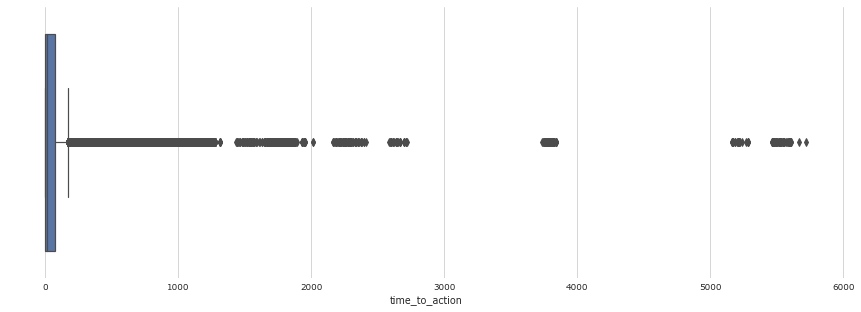

In [272]:
#sns.violinplot(data=, palette="Set3", bw=.2, cut=1, linewidth=1)
plt.figure(figsize=(15,5))
sns.boxplot(x=df.time_to_action)
plt.show()

Looks like there are outliers.

We are going to remove all upper outliers that are 2 standard deviations away or more.

In [273]:
# Calculate summary statistics
data_mean, data_std = np.mean(df.time_to_action), np.std(df.time_to_action)
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off

# Identify outliers
outliers = [x for x in df.time_to_action if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

# remove outliers
outliers_removed = [x for x in df.time_to_action if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Identified outliers: 3517
Non-outlier observations: 97219


In [274]:
df = df[df.time_to_action < upper]

In [275]:
df.shape

(97219, 34)

We now have 97,219 records.

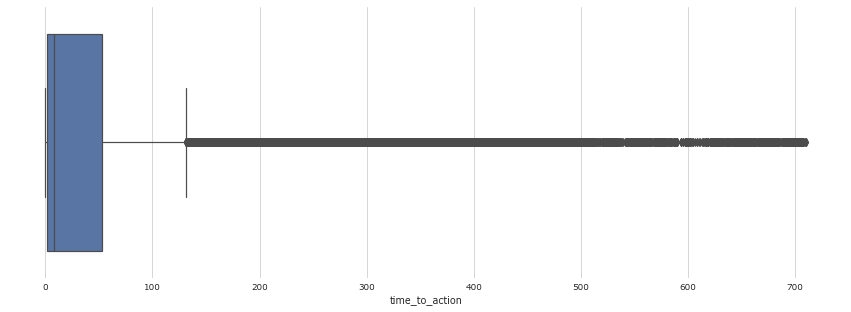

In [276]:
#sns.violinplot(data=, palette="Set3", bw=.2, cut=1, linewidth=1)
plt.figure(figsize=(15,5))
sns.boxplot(x=df.time_to_action)
plt.show()

## Data Cleaning - Part 2

#### Drop unnecessary data

In [277]:
df.drop(columns=[
    'entry_id',
    'job_id',
    'p_id',
    'c_id',
    'role_id',
    'date_declined',
    'date_applied',
    'date_rejected',
    'date_hired',
    'date_job_created',
    'job_latitude',
    'job_longitude',
    'worker_latitude',
    'worker_longitude',
], axis=1, inplace=True)

#### Fill NA values

In [278]:
df.wage_applied_role.fillna(0, inplace=True)
df.wage_hired_role.fillna(0, inplace=True)
df.job_wage.fillna(0, inplace=True)

#### Final check for NA values

In [279]:
df.isnull().sum()

country_id                0
status                    0
job_title_length          0
job_description_length    0
job_time_dow_from         0
job_time_hour_from        0
job_time_dow_to           0
job_time_hour_to          0
job_wage                  0
num_applied_role          0
num_rejected_role         0
num_applied_company       0
num_rejected_company      0
wage_applied_role         0
wage_hired_role           0
num_hired_role            0
num_hired_company         0
has_distance              0
distance_to_job           0
time_to_action            0
dtype: int64

#### Separate DE and UK data

In [280]:
df_uk = df[df.country_id == 2]
df_de = df[df.country_id == 1]

# Drop platform IDs since they are no longer necessary
df.drop(columns=['country_id'], axis=1, inplace=True)
df_uk.drop(columns=['country_id'], axis=1, inplace=True)
df_de.drop(columns=['country_id'], axis=1, inplace=True)

/Users/ivan.khokhlov/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Final check before proceeding with the algorithm

In [284]:
df_de.shape

(71263, 19)

In [281]:
df_de.head()

,status,job_title_length,job_description_length,job_time_dow_from,job_time_hour_from,job_time_dow_to,job_time_hour_to,job_wage,num_applied_role,num_rejected_role,num_applied_company,num_rejected_company,wage_applied_role,wage_hired_role,num_hired_role,num_hired_company,has_distance,distance_to_job,time_to_action
0,1,49,542,1,11,1,16,25.00,7,0,0,0,25.068571,0.0,0,0,1,17.620530,13.558889
1,1,18,47,3,19,3,23,23.32,6,0,0,0,25.360000,0.0,0,0,1,14.951225,26.018056
2,1,40,1298,7,9,7,18,25.50,2,0,0,0,25.450000,0.0,0,0,1,7.411042,38.804167
3,1,18,425,6,11,6,12,27.00,4,2,0,0,27.000000,0.0,0,0,1,3.021688,1.305278
4,1,18,425,6,11,6,12,27.00,2,0,2,0,27.000000,0.0,0,0,1,7.380269,1.279167


In [285]:
df_uk.shape

(25942, 19)

In [282]:
df_uk.head()

,status,job_title_length,job_description_length,job_time_dow_from,job_time_hour_from,job_time_dow_to,job_time_hour_to,job_wage,num_applied_role,num_rejected_role,num_applied_company,num_rejected_company,wage_applied_role,wage_hired_role,num_hired_role,num_hired_company,has_distance,distance_to_job,time_to_action
22,1,48,167,2,18,6,23,9.20,4,0,0,0,8.9275,0.0,0,0,1,6.015908,8.647500
24,1,33,803,1,10,1,14,10.00,7,2,3,1,8.8400,0.0,2,0,1,0.618073,106.901667
32,1,33,803,1,10,1,14,10.00,3,0,0,0,8.5700,0.0,0,0,1,3.030629,106.837500
36,1,50,84,7,19,1,5,12.00,0,0,0,0,0.0000,0.0,0,0,1,3.876036,2.579444
37,1,62,360,7,18,1,0,8.21,2,0,0,0,8.7500,0.0,0,0,1,4.265440,5.923333


Save all the dataframes into CSVs:

In [286]:
df.to_csv('full_abt_eds.csv', index=None)
df_uk.to_csv('uk_abt_eds.csv', index=None)
df_de.to_csv('de_abt_eds.csv', index=None)

## Further Data Analysis - UK

Since the client is primarily interested in building a model for their UK operations, we'll focus on that.

In [287]:
df_uk = pd.read_csv('uk_abt_eds.csv')

In [289]:
correlations = df_uk.corr()

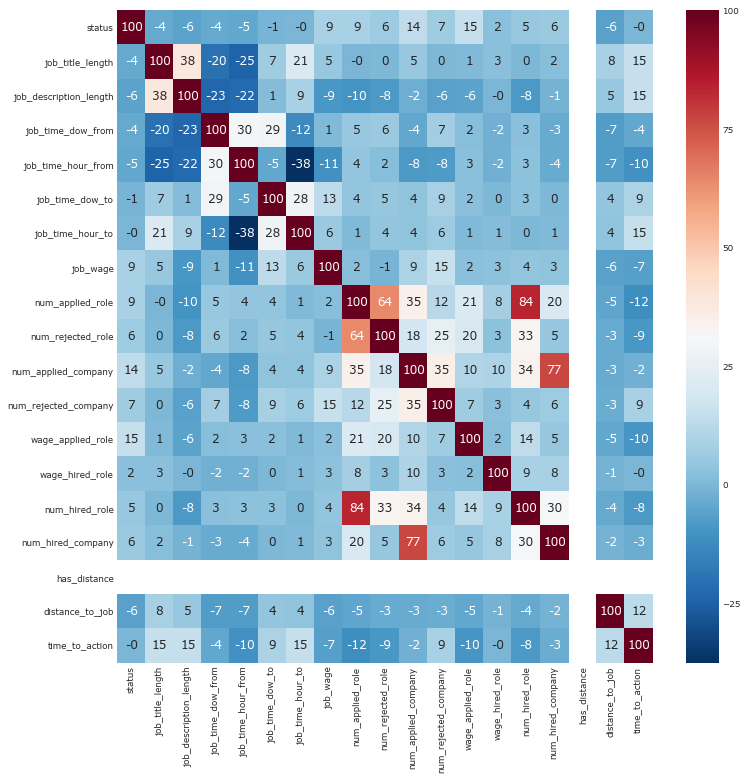

In [290]:
# Change the figure size
plt.figure(figsize=(12,12))

# Plot heatmap of correlations
sns.heatmap(correlations*100, cmap='RdBu_r', annot_kws={"size": 12}, annot=True,  fmt='.0f')
plt.show()

## Algorithm Selection

#### Choosing Algorithms

This is a classification problem.

The end model should be able to provide a probability that a person will apply for a job.

This probability will be used to sort jobs for the end users in a relevant way.

Therefore, the following algorithms will be used:
* LogisticRegression
* RandomForesstClassifier
* GradientBoostinClassifier

In addition, another classification algorithm will be tested:
* XGBoost (https://xgboost.readthedocs.io/en/latest/#)

#### Choosing Hyperparameters

__LogisticRegression__
* C

__RandomForestClassifier__
* n_estimators
* max_features
* min_samples_leaf
* max_samples_split
* max_depth

__GradientBoostingClassifier__
* n_estimators
* learning_rate
* max_depth
* min_samples_split

__XGBoost__
* n_estimators
* learning_rate

In a section below we'll explore which specific values to chose for each hyperparameter.

## Model Training

### Importing the necessary libraries

In [310]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from matplotlib.legend_handler import HandlerLine2D

### Split the dataset into training and testing

Remember that we need to stratify when splitting the data since we have slightly a slightly imbalanced class.

#### UK

In [245]:
df_uk = pd.read_csv('uk_abt_eds.csv')
y = df_uk.status
x = df_uk.drop('status', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=df_uk.status)
print(len(x_train), len(x_test), len(y_train), len(y_test))

20753 5189 20753 5189


In [292]:
df_uk.groupby(['status']).count()

,job_title_length,job_description_length,job_time_dow_from,job_time_hour_from,job_time_dow_to,job_time_hour_to,job_wage,num_applied_role,num_rejected_role,num_applied_company,num_rejected_company,wage_applied_role,wage_hired_role,num_hired_role,num_hired_company,has_distance,distance_to_job,time_to_action
status,,,,,,,,,,,,,,,,,,
0,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746,11746
1,14196,14196,14196,14196,14196,14196,14196,14196,14196,14196,14196,14196,14196,14196,14196,14196,14196,14196


In the next section we'll decide which range of values to try for each hyperparameter for each algorithm.

## Helper functions for hyperparameters

In [293]:
# Function to plot a graph for the AUC score for each hyperparameter

def hyperparam_chart(param_name, param_values, train_results, test_results):
    line1, = plt.plot(param_values, train_results, 'b', label='Train AUC')
    line2, = plt.plot(param_values, test_results, 'r', label='Test AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel(param_name)
    plt.show()

## Chosing Hyperparameter Values

### LogisticRegression (L1 penalty)

#### Choosing input for C hyperparameter

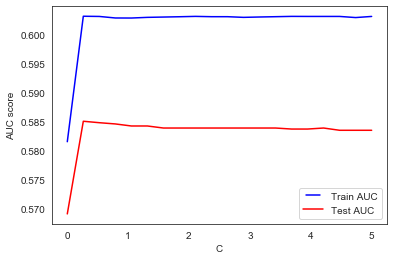

In [119]:
param_values = np.linspace(0.001, 5, 20, endpoint=True)
train_results = []
test_results = []

for C_value in param_values:
    model = LogisticRegression(C=C_value, penalty='l1', solver='liblinear')
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
hyperparam_chart('C', param_values, train_results, test_results)

### GradientBoostingClassifier

#### Choosing input for n_estimators hyperparameter

n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

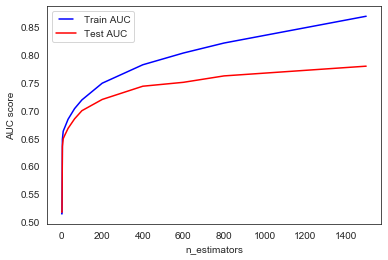

In [121]:
param_values = [1, 2, 4, 8, 16, 32, 64, 100, 200, 400, 600, 800, 1500]
train_results = []
test_results = []

for estimator in param_values:
    model = GradientBoostingClassifier(n_estimators=estimator)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
hyperparam_chart('n_estimators', param_values, train_results, test_results)

#### Choosing input for learning_rate hyperparameter

Learning rate shrinks the contribution of each tree by learning_rate.

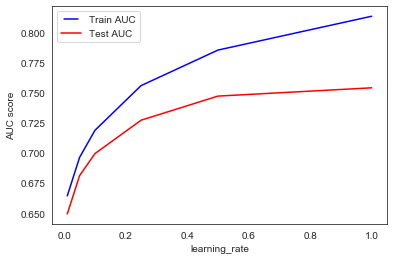

In [122]:
param_values = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []

for eta in param_values:
    model = GradientBoostingClassifier(learning_rate=eta)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
hyperparam_chart('learning_rate', param_values, train_results, test_results)

#### Choosing input for max_depth hyperparameter

This indicates how deep the built tree can be. The deeper the tree, the more splits it has and it captures more information about how the data. We fit a decision tree with depths ranging from 1 to 32 and plot the training and test errors.

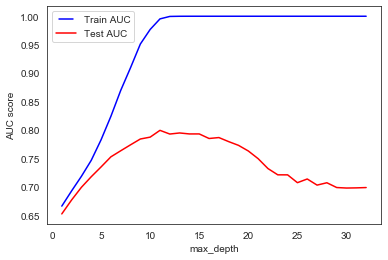

In [123]:
param_values = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in param_values:
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
hyperparam_chart('max_depth', param_values, train_results, test_results)

#### Choosing input for min_samples_split hyperparameter

This represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

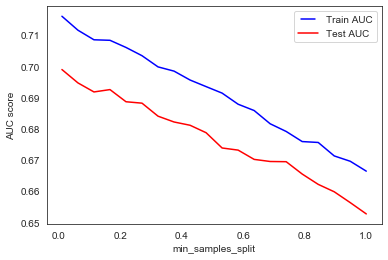

In [126]:
param_values = np.linspace(0.01, 1, 20, endpoint=True)
train_results = []
test_results = []

for min_samples_split in param_values:
    model = GradientBoostingClassifier(min_samples_split=min_samples_split)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
hyperparam_chart('min_samples_split', param_values, train_results, test_results)

#### Choosing input for min_samples_leaf hyperparameter

This is the minimum number of samples required to be at a leaf node. This is similar to min_samples_splits, however, this describe the minimum number of samples at the leafs.

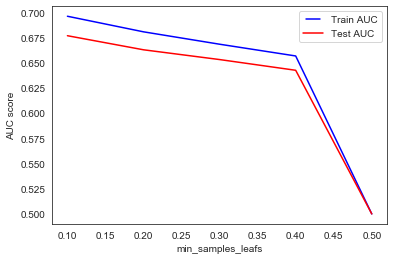

In [127]:
param_values = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in param_values:
    model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

hyperparam_chart('min_samples_leafs', param_values, train_results, test_results)

#### Choosing input for max_features hyperparameter

max_features represents the number of features to consider when looking for the best split.

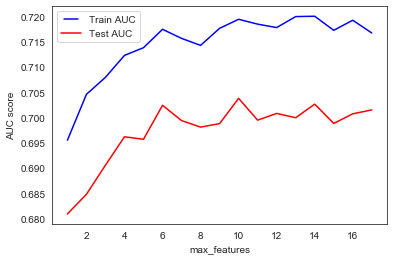

In [128]:
param_values = list(range(1,x_train.shape[1]))
train_results = []
test_results = []

for max_feature in param_values:
    model = GradientBoostingClassifier(max_features=max_feature)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
hyperparam_chart('max_features', param_values, train_results, test_results)

### XGBoostClassifier

#### Choosing input for n_estimators hyperparameter

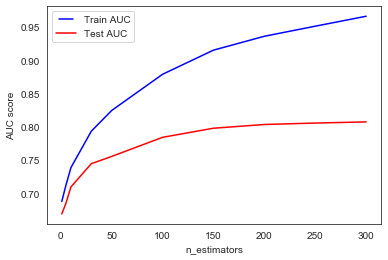

In [129]:
param_values = [1,5,10,30,50,100,150,200,250,300]
train_results = []
test_results = []

for estimator in param_values:
    model = xgb.XGBClassifier(n_estimators=estimator)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
hyperparam_chart('n_estimators', param_values, train_results, test_results)

#### Choosing input for learning_rate hyperparameter

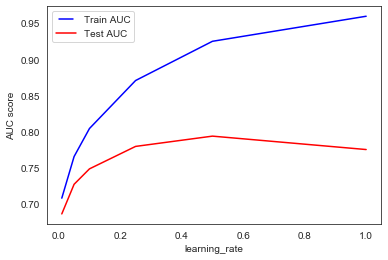

In [130]:
param_values = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []

for eta in param_values:
    model = xgb.XGBClassifier(learning_rate=eta)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
hyperparam_chart('learning_rate', param_values, train_results, test_results)

### RandomForestClassifier

#### Choosing input for n_estimators hyperparameter

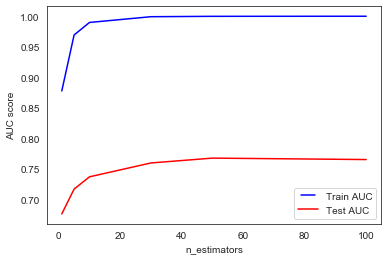

In [131]:
param_values = [1,5,10,30,50,100]
train_results = []
test_results = []

for estimator in param_values:
    model = RandomForestClassifier(n_estimators=estimator)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
hyperparam_chart('n_estimators', param_values, train_results, test_results)

## Set the values for all the hyperparameters

The values are partly determined by the investigation above into the values of the hyperparameters.

In [294]:
logistic_hyperparameters = {
    'logisticregression__C' : np.linspace(0.001, 5, 20, endpoint=True)
}

gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [500, 1000, 1500, 1700, 2000],
    'gradientboostingclassifier__learning_rate': [0.1, 0.5, 1],
    'gradientboostingclassifier__max_depth': np.linspace(5, 15, 11, endpoint=True),
    'gradientboostingclassifier__min_samples_split': np.linspace(0.01, 0.3, 10, endpoint=True),
    'gradientboostingclassifier__min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'gradientboostingclassifier__max_features': ['auto', 'sqrt', 0.33]
}

xgb_hyperparameters = {
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__n_estimators': [100,150,200,250,300,350,400],
    'xgbclassifier__learning_rate': [0.1, 0.5, 1]
}

rf_hyperparameters = {
    'randomforestclassifier__n_estimators' : [1,5,10,30,50,100],
    'randomforestclassifier__max_depth' : np.linspace(5, 12, 8, endpoint=True),
    'randomforestclassifier__min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 0.33]
}

hyperparameters = {
    'l1' : logistic_hyperparameters,
    'l2' : logistic_hyperparameters,
    'gb' : gb_hyperparameters,
    'xgb' : xgb_hyperparameters,
    'rf' : rf_hyperparameters
}

## Prepare the pipelines

In [295]:
pipelines = {
    'l1' : make_pipeline(StandardScaler(),
                        LogisticRegression(
                            penalty='l1', 
                            solver='liblinear',
                            random_state=777)),
    'l2' : make_pipeline(StandardScaler(),
                        LogisticRegression(
                            penalty='l2', 
                            solver='liblinear',
                            random_state=777)),
    'gb' : make_pipeline(StandardScaler(),
                        GradientBoostingClassifier(
                        random_state=777)),
    'xgb' : make_pipeline(StandardScaler(),
                        xgb.XGBClassifier(
                        random_state=777)),
    'rf' : make_pipeline(StandardScaler(),
                        RandomForestClassifier(
                        random_state=777))
}

## Prepare GridSearchCV

A comprehensive GridSearchCV was attempted, however it was too time consuming, and RandomizedSearchCV was chosen for faster results.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

We will set __scoring='roc_auc'__ in order to focus on the area under the ROC as the primary optimization metric.

In [ ]:
fitted_models = {}

for model_name, model_pipeline in pipelines.items():
    print('\nStarting to fit: {}'.format(model_name))
    
    # Fit each model
    model = GridSearchCV(
        pipelines[model_name],
        hyperparameters[model_name],
        cv      = 2,   # 2 fold cross-validation
        n_jobs  = -1,  # Use all my computer's power
        verbose = 10,
        scoring = 'roc_auc'
    )
    
    model.fit(x_train, y_train)
    fitted_models[model_name] = model
    
    # Immediately calculate the roc_score for the model:
    pred = model.predict_proba(x_test)
    pred_proba = [p[1] for p in pred]
    roc_score = roc_auc_score(y_test, pred_proba)
    
    print('\n\nModel {} has been fitted. ROC AUC: {}\n'.format(model_name, roc_score))

## Prepare RandomizedSearchCV

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

We will set __scoring='roc_auc'__ in order to focus on the area under the ROC as the primary optimization metric.

Note: remember to set the __n_iter__ parameter to limit the amount of iterations.

In [298]:
fitted_models = {}

for model_name, model_pipeline in pipelines.items():
    print('\nStarting to fit: {}'.format(model_name))
    
    # Fit each model
    model = RandomizedSearchCV(
        pipelines[model_name],
        hyperparameters[model_name],
        n_iter    = 40,
        n_jobs    = -1, # Use all my computer's power
        cv        = 3,  # The default value of this will change to 5 in version 0.22
        verbose   = 10,
        scoring   = 'roc_auc'
    )
    
    model.fit(x_train, y_train)
    fitted_models[model_name] = model
    
    # Calculate predictions
    y_pred = model.predict(x_test)  # y_pred = predicted Y value
    y_pred_proba_prep = model.predict_proba(x_test) 
    y_pred_proba = [p[1] for p in y_pred_proba_prep] # y_pred_proba = the probability of the prediction

    # Calculate all the performance scores:
    roc_score = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    
    print('''\n\nModel {} has been fitted. \n
          ROC AUC: {}\n
          Precision: {}\n
          Recall: {}\n
          F1: {}\n
          '''.format(model_name, roc_score, precision, recall, f1)
         )


Starting to fit: l1
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ivan.khokhlov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 20 is smaller than n_iter=40. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:    3.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed:    4.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:    4.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.1s finished




Model l1 has been fitted. 

          ROC AUC: 0.6544527488472769

          Precision: 0.6242953776775648

          Recall: 0.7799295774647887

          F1: 0.6934877896055104

          

Starting to fit: l2
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ivan.khokhlov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 20 is smaller than n_iter=40. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1642s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  23 out of  60 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  30 out of  60 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of



Model l2 has been fitted. 

          ROC AUC: 0.6544301141030945

          Precision: 0.6242953776775648

          Recall: 0.7799295774647887

          F1: 0.6934877896055104

          

Starting to fit: gb
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 110 out of 120 | elapsed:  1.9min remaining:   10.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.0min finished




Model gb has been fitted. 

          ROC AUC: 0.8603232421348012

          Precision: 0.7938180540920267

          Recall: 0.795774647887324

          F1: 0.7947951468260945

          

Starting to fit: xgb
Fitting 3 folds for each of 21 candidates, totalling 63 fits


/Users/ivan.khokhlov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 21 is smaller than n_iter=40. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done  47 out of  63 | elapsed:   52.1s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  54 out of  63 | elapsed:  1.1min remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  61 out of  63 | elapsed:  1.2min remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:  1.2min finished




Model xgb has been fitted. 

          ROC AUC: 0.8894403671925123

          Precision: 0.823549965059399

          Recall: 0.8299295774647887

          F1: 0.8267274640477026

          

Starting to fit: rf
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0939s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  32 out of 120 | elapsed:    1.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  84 out of 120 | elapsed:    2.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.1s finished




Model rf has been fitted. 

          ROC AUC: 0.7116419783066212

          Precision: 0.6957708049113234

          Recall: 0.7183098591549296

          F1: 0.706860706860707

          


## Feature Importances for Winning Model

__Model xgb is the best performer with an ROC AUC score of 0.89__

Below is a plot of features based on their relative importance.

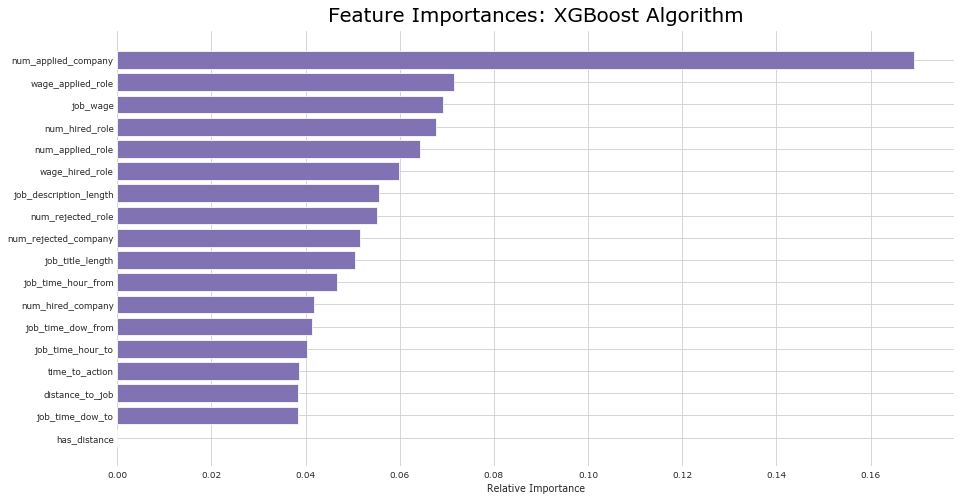

In [306]:
importances = fitted_models['xgb'].best_estimator_.named_steps["xgbclassifier"].feature_importances_
features = x_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(15,8))
plt.title('Feature Importances: XGBoost Algorithm', **title_font)
plt.barh(range(len(indices)), importances[indices], color='m', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

__Model GB is the 2nd best performer (not far behind XGB) with an ROC AUC score of 0.86__

Below is a plot of features based on their relative importance.

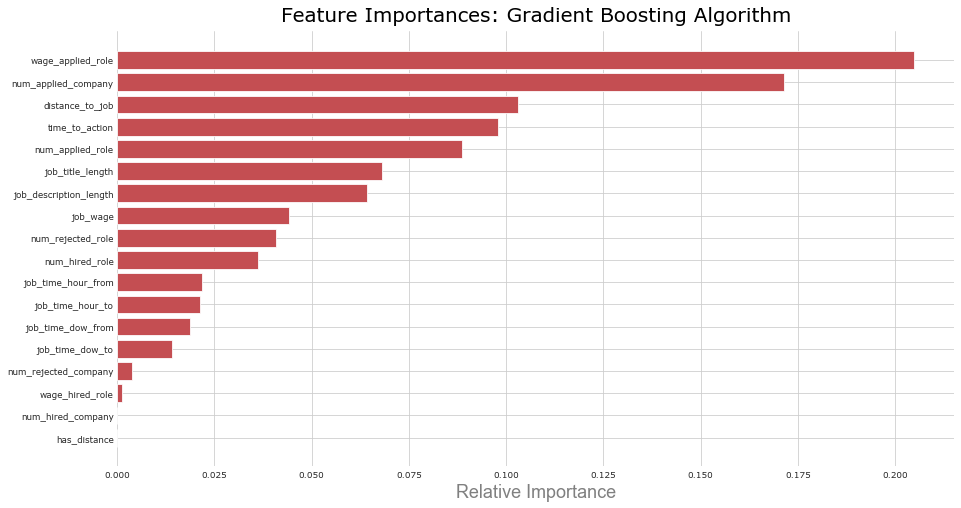

In [307]:
importances = fitted_models['gb'].best_estimator_.named_steps["gradientboostingclassifier"].feature_importances_
features = x_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(15,8))
plt.title('Feature Importances: Gradient Boosting Algorithm', **title_font)
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', **axis_font)
plt.show()

#### Insights:
* Both algorithms seem to emphasize importance on different features
* As an improvement in the next algorithm iteration "has_distance" can probably be dropped. In almost all cases there is a distance, hence it probably has little importance in the model.
* The number of jobs a worker applied for in the past with the same company seems to play a very important role in predicting what job a worker will apply for in the future

## Confusion Matrix for Winning Model

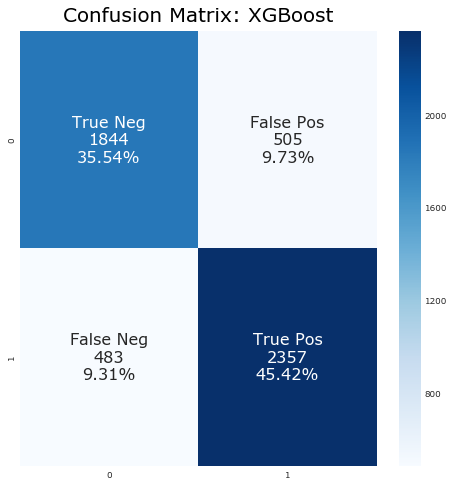

In [301]:
pred = fitted_models['xgb'].predict(x_test)
cf_matrix = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in  cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix: XGBoost', **title_font)
sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 16}, fmt='', cmap='Blues')
plt.show()

## ROC Curve for Winning Model

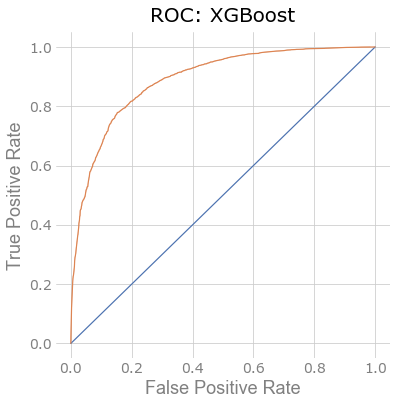

In [304]:
# Get the data:
pred = fitted_models['xgb'].predict_proba(x_test)
pred_proba = [p[1] for p in pred]
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

# Set the style properties:
plt.figure(figsize=(6,6))
plt.title('ROC: XGBoost', **title_font)
plt.ylabel('True Positive Rate', **axis_font)
plt.xlabel('False Positive Rate', **axis_font)
plt.xticks(**ticks_font)  # rotation=90
plt.yticks(**ticks_font)  # rotation=90

# Plot the data:
sns.lineplot(x=[0,1], y=[0,1])
sns.lineplot(x=fpr, y=tpr) # marker="o"
plt.show()

## Final performance recap for the winning model

In [309]:
# Set the winning model:
model = 'xgb'

# Calculate predictions
y_pred = fitted_models[model].predict(x_test)  # y_pred = predicted Y value
y_pred_proba_prep = fitted_models[model].predict_proba(x_test) 
y_pred_proba = [p[1] for p in y_pred_proba_prep] # y_pred_proba = the probability of the prediction

# Calculate all the performance scores:
roc_score = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1= f1_score(y_test,y_pred)

print(''' 
            ROC AUC: {}\n
            Precision: {}\n
            Recall: {}\n
            F1: {}\n
'''.format(roc_score, precision, recall, f1))

 
            ROC AUC: 0.8894403671925123

            Precision: 0.823549965059399

            Recall: 0.8299295774647887

            F1: 0.8267274640477026




## Insights & Analysis

The higher tha area under the ROC curve (AUC), the better the classifier. A classifier with an AUC higher than 0.5 is better than a random classifier. In our project we have achieved AUROC score of 0.89 using the XGBoost algorithm, which is excellent.

The model can now be exported and hosted by the client is a point of inference, e.g. on AWS Sagemaker, in order to improve the relevancy of their jobs marketplace.

__Some important insights:__
* The model identified that in the UK the following play an important role in determining if someone will apply for a job:
    * Number of previous applications to a particular company
    * The average wage of previously applied roles
    * The wage of the job
    * The number of times a worker was previously hired by the company

__Further recommendations:__
* Different models will probably be required for different markets
* Some features could potentially be dropped, e.g. 'has_distance'
* Comprehensive hyperparamter search should be carried out
* Specifically for XGBoost more hyperparameters should be tested
* New features can be tested:
    * How many times a worker viewed a particular job
    * Quantity of times a worker has declined different job types